In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, cross_val_score
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, precision_recall_curve

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
train_data = pd.read_csv('training.csv', sep=',')
test_data = pd.read_csv('test.csv', sep=',')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
TransactionId           95662 non-null object
BatchId                 95662 non-null object
AccountId               95662 non-null object
SubscriptionId          95662 non-null object
CustomerId              95662 non-null object
CurrencyCode            95662 non-null object
CountryCode             95662 non-null int64
ProviderId              95662 non-null object
ProductId               95662 non-null object
ProductCategory         95662 non-null object
ChannelId               95662 non-null object
Amount                  95662 non-null float64
Value                   95662 non-null int64
TransactionStartTime    95662 non-null object
PricingStrategy         95662 non-null int64
FraudResult             95662 non-null int64
dtypes: float64(1), int64(4), object(11)
memory usage: 11.7+ MB


In [4]:
train_data.nunique()

TransactionId           95662
BatchId                 94809
AccountId                3633
SubscriptionId           3627
CustomerId               3742
CurrencyCode                1
CountryCode                 1
ProviderId                  6
ProductId                  23
ProductCategory             9
ChannelId                   4
Amount                   1676
Value                    1517
TransactionStartTime    94556
PricingStrategy             4
FraudResult                 2
dtype: int64

In [5]:
train_data.drop(['CurrencyCode', 'CountryCode'], axis=1, inplace=True)


testTransId = test_data['TransactionId']
test_data.drop(['TransactionId', 'CurrencyCode', 'CountryCode'], axis=1, inplace=True)

In [6]:
train_data.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount',
       'Value', 'TransactionStartTime', 'PricingStrategy', 'FraudResult'],
      dtype='object')

Amount and Value

In [7]:
train_data['Amount'] = train_data['Amount'].astype(int)
test_data['Amount'] = train_data['Amount'].astype(int)

train_data = train_data.drop(['Value'], axis=1).rename({'Amount' : 'Value'}, axis=1)
test_data = test_data.drop(['Value'], axis=1).rename({'Amount' : 'Value'}, axis=1)

In [8]:
train_data['TransactionStartTime']

0        2018-11-15T02:18:49Z
1        2018-11-15T02:19:08Z
2        2018-11-15T02:44:21Z
3        2018-11-15T03:32:55Z
4        2018-11-15T03:34:21Z
5        2018-11-15T03:35:10Z
6        2018-11-15T03:44:31Z
7        2018-11-15T03:45:13Z
8        2018-11-15T04:14:59Z
9        2018-11-15T04:31:48Z
10       2018-11-15T04:32:08Z
11       2018-11-15T04:32:42Z
12       2018-11-15T04:35:10Z
13       2018-11-15T04:47:31Z
14       2018-11-15T04:48:09Z
15       2018-11-15T04:51:20Z
16       2018-11-15T04:52:37Z
17       2018-11-15T04:54:00Z
18       2018-11-15T04:54:18Z
19       2018-11-15T04:56:25Z
20       2018-11-15T04:57:00Z
21       2018-11-15T04:59:02Z
22       2018-11-15T04:59:41Z
23       2018-11-15T04:59:51Z
24       2018-11-15T05:06:25Z
25       2018-11-15T05:06:39Z
26       2018-11-15T05:37:24Z
27       2018-11-15T05:38:25Z
28       2018-11-15T05:38:35Z
29       2018-11-15T05:38:37Z
                 ...         
95632    2019-02-13T09:30:56Z
95633    2019-02-13T09:30:59Z
95634    2

In [9]:
def trans_time(time_of_trans):
    date = time_of_trans.split('T')[0]
    date_split = date.split('-')
    
    yr, mnth, dy = date_split[0], date_split[1], date_split[2]
    
    
    if (yr=='2018') & (mnth=='11'):
        return 'November'
    elif (yr=='2018') & (mnth=='12'):
        return 'December'
    elif (yr=='2019') & (mnth=='01'):
        return 'January'
    elif (yr=='2019') & (mnth=='02'):
        return 'February'
    elif (yr=='2019') & (mnth=='03'):
        return 'March'
        
    
train_data['TransactionStartTime'] = train_data['TransactionStartTime'].map(trans_time)
test_data['TransactionStartTime'] = test_data['TransactionStartTime'].map(trans_time)

In [10]:
train_data['TransactionStartTime'].value_counts()#.values.sum()

December    35635
January     31783
February    15772
November    12472
Name: TransactionStartTime, dtype: int64

In [11]:
test_data['TransactionStartTime'].value_counts()#.values.sum()

February    23653
March       21366
Name: TransactionStartTime, dtype: int64

training data spans nov to feb, while test data spans feb to mar

In [12]:
train_data.head(3)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000,November,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20,November,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500,November,2,0


In [13]:
test_data.head(3)

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Value,TransactionStartTime,PricingStrategy
0,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000,February,4
1,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,ProviderId_5,ProductId_15,financial_services,ChannelId_3,-20,February,2
2,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,ProviderId_4,ProductId_6,financial_services,ChannelId_2,500,February,2


Channel

In [14]:
test_data['ChannelId'].value_counts()

ChannelId_3    38090
ChannelId_2     6198
ChannelId_5      602
ChannelId_1      102
ChannelId_4       27
Name: ChannelId, dtype: int64

In [15]:
train_data['ChannelId'].value_counts()

ChannelId_3    56935
ChannelId_2    37141
ChannelId_5     1048
ChannelId_1      538
Name: ChannelId, dtype: int64

Train data ChannelId lacks pay 'later'

In [16]:
test_data['ProductCategory'].value_counts()

financial_services    21700
airtime               20923
data_bundles            914
utility_bill            740
tv                      459
retail                  184
movies                   78
ticket                   16
transport                 5
Name: ProductCategory, dtype: int64

In [17]:
print('Train Data')
print('Min Value: {}'.format(train_data['Value'].min()))
print('Max Value: {}'.format(train_data['Value'].max()))
print('Mean: {}'.format(train_data['Value'].mean()))
print()
print('Test Data')
print('Min Value: {}'.format(test_data['Value'].min()))
print('Max Value: {}'.format(test_data['Value'].max()))
print('Mean: {}'.format(test_data['Value'].mean()))

Train Data
Min Value: -1000000
Max Value: 9880000
Mean: 6717.848111057682

Test Data
Min Value: -200000
Max Value: 5000000
Mean: 5459.708523068038


In [18]:
train_data['ProviderId'].value_counts()

ProviderId_4    38189
ProviderId_6    34186
ProviderId_5    14542
ProviderId_1     5643
ProviderId_3     3084
ProviderId_2       18
Name: ProviderId, dtype: int64

In [19]:
train_data.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult'],
      dtype='object')

In [20]:
train_data.nunique()

TransactionId           95662
BatchId                 94809
AccountId                3633
SubscriptionId           3627
CustomerId               3742
ProviderId                  6
ProductId                  23
ProductCategory             9
ChannelId                   4
Value                    1514
TransactionStartTime        4
PricingStrategy             4
FraudResult                 2
dtype: int64

In [21]:
train_data['ProviderId'].value_counts()

ProviderId_4    38189
ProviderId_6    34186
ProviderId_5    14542
ProviderId_1     5643
ProviderId_3     3084
ProviderId_2       18
Name: ProviderId, dtype: int64

In [22]:
train_data['ProductCategory'].unique()

array(['airtime', 'financial_services', 'utility_bill', 'data_bundles',
       'tv', 'transport', 'ticket', 'movies', 'other'], dtype=object)

In [23]:
test_data['ProductId'].value_counts()

ProductId_6     15186
ProductId_3     10310
ProductId_10     8482
ProductId_15     6007
ProductId_1      1212
ProductId_4       875
ProductId_11      867
ProductId_21      566
ProductId_14      473
ProductId_19      334
ProductId_26      184
ProductId_13      105
ProductId_24       78
ProductId_8        74
ProductId_22       69
ProductId_7        42
ProductId_2        41
ProductId_16       35
ProductId_25       31
ProductId_20       16
ProductId_27        9
ProductId_18        7
ProductId_17        6
ProductId_5         5
ProductId_9         3
ProductId_23        2
Name: ProductId, dtype: int64

In [24]:
train_data.head(3)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000,November,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20,November,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500,November,2,0


In [25]:
train_data.head(3)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000,November,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20,November,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500,November,2,0


In [26]:
len(train_data['BatchId'].unique())

94809

In [27]:
len(train_data)

95662

In [28]:
train_data['BatchId'].unique()

array(['BatchId_36123', 'BatchId_15642', 'BatchId_53941', ...,
       'BatchId_118602', 'BatchId_70924', 'BatchId_29317'], dtype=object)

In [29]:
def batch(batch_id):
    batch_id_split = batch_id.split('_')
    batch_id = int(batch_id_split[1])
    
    if batch_id <= 20000:
        return 'first_batch'
    elif (batch_id > 20000) & (batch_id <= 40000):
        return 'second_batch'
    elif (batch_id > 40000) & (batch_id <= 60000):
        return 'third_batch'
    elif (batch_id > 60000) & (batch_id <= 80000):
        return 'fourth_batch'
    elif (batch_id > 80000) & (batch_id <= 100000):
        return 'fifth_batch'
    elif (batch_id > 100000) & (batch_id <= 120000):
        return 'sixth_batch'
    elif (batch_id > 120000) & (batch_id <= 140000):
        return 'seventh_batch'
    

train_data['BatchId'] = train_data['BatchId'].map(batch)
test_data['BatchId'] = test_data['BatchId'].map(batch)

In [30]:
test_data.head(3)

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Value,TransactionStartTime,PricingStrategy
0,second_batch,AccountId_2441,SubscriptionId_4426,CustomerId_2857,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000,February,4
1,third_batch,AccountId_3439,SubscriptionId_2643,CustomerId_3874,ProviderId_5,ProductId_15,financial_services,ChannelId_3,-20,February,2
2,fourth_batch,AccountId_4841,SubscriptionId_3829,CustomerId_2857,ProviderId_4,ProductId_6,financial_services,ChannelId_2,500,February,2


In [31]:
train_data.drop('TransactionId', axis=1, inplace=True)

In [32]:
train_data['SubscriptionId'].nunique()

3627

In [33]:
train_data.drop('ProductId', axis=1, inplace=True)
test_data.drop('ProductId', axis=1, inplace=True)

In [34]:
train_data.head(3)

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductCategory,ChannelId,Value,TransactionStartTime,PricingStrategy,FraudResult
0,second_batch,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,airtime,ChannelId_3,1000,November,2,0
1,first_batch,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,financial_services,ChannelId_2,-20,November,2,0
2,third_batch,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,airtime,ChannelId_3,500,November,2,0


In [35]:
train_data.drop(['AccountId', 'SubscriptionId', 'CustomerId'], axis=1, inplace=True)
test_data.drop(['AccountId', 'SubscriptionId', 'CustomerId'], axis=1, inplace=True)

In [36]:
train_data.head(3)

,BatchId,ProviderId,ProductCategory,ChannelId,Value,TransactionStartTime,PricingStrategy,FraudResult
0,second_batch,ProviderId_6,airtime,ChannelId_3,1000,November,2,0
1,first_batch,ProviderId_4,financial_services,ChannelId_2,-20,November,2,0
2,third_batch,ProviderId_6,airtime,ChannelId_3,500,November,2,0


In [37]:
train_data['BatchId'].value_counts()

seventh_batch    14197
fifth_batch      13658
fourth_batch     13658
sixth_batch      13589
third_batch      13588
first_batch      13513
second_batch     13459
Name: BatchId, dtype: int64

In [38]:
train_data.corr()

,Value,PricingStrategy,FraudResult
Value,1.000000,-0.061931,0.557370
PricingStrategy,-0.061931,1.000000,-0.033821
FraudResult,0.557370,-0.033821,1.000000


In [39]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
value = train_data['Value']
fraud = train_data['FraudResult']
x = train_data.drop(['Value', 'FraudResult'], axis=1)

x = x.apply(enc.fit_transform)
x = pd.concat([x, fraud, value], axis=1)
x.corrwith(x['FraudResult'])

BatchId                 0.001870
ProviderId             -0.051937
ProductCategory         0.028691
ChannelId               0.027754
TransactionStartTime   -0.002695
PricingStrategy        -0.051744
FraudResult             1.000000
Value                   0.557370
dtype: float64

In [40]:
from sklearn.preprocessing import StandardScaler

In [41]:
fraudResult = train_data['FraudResult']
value_train = train_data['Value']
value_test = test_data['Value']


train_data = train_data.drop(['FraudResult', 'Value'], axis=1)
test_data = test_data.drop('Value', axis=1)

train_data['label'] = 1
test_data['label'] = 0

combined = pd.concat([train_data, test_data], axis=0)

combined = pd.get_dummies(combined, columns=train_data.columns[:-1], drop_first=True)

train_data = combined[combined['label']==1]
test_data = combined[combined['label']==0]

train_data.drop('label', axis=1, inplace=True)
test_data.drop('label', axis=1, inplace=True)

train_data = pd.concat([train_data, value_train, fraudResult], axis=1)
test_data = pd.concat([test_data, value_test], axis=1)

C:\Users\Immanuel\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [42]:
print(train_data.shape)
print(test_data.shape)

(95662, 33)
(45019, 32)


In [43]:
print(train_data.isnull().sum().max())
print(test_data.isnull().sum().max())

0
0


In [44]:
train_data.columns

Index(['BatchId_first_batch', 'BatchId_fourth_batch', 'BatchId_second_batch',
       'BatchId_seventh_batch', 'BatchId_sixth_batch', 'BatchId_third_batch',
       'ProviderId_ProviderId_2', 'ProviderId_ProviderId_3',
       'ProviderId_ProviderId_4', 'ProviderId_ProviderId_5',
       'ProviderId_ProviderId_6', 'ProductCategory_data_bundles',
       'ProductCategory_financial_services', 'ProductCategory_movies',
       'ProductCategory_other', 'ProductCategory_retail',
       'ProductCategory_ticket', 'ProductCategory_transport',
       'ProductCategory_tv', 'ProductCategory_utility_bill',
       'ChannelId_ChannelId_2', 'ChannelId_ChannelId_3',
       'ChannelId_ChannelId_4', 'ChannelId_ChannelId_5',
       'TransactionStartTime_February', 'TransactionStartTime_January',
       'TransactionStartTime_March', 'TransactionStartTime_November',
       'PricingStrategy_1', 'PricingStrategy_2', 'PricingStrategy_4', 'Value',
       'FraudResult'],
      dtype='object')

In [45]:
train_data.corrwith(train_data['FraudResult'])

BatchId_first_batch                   0.000493
BatchId_fourth_batch                  0.002294
BatchId_second_batch                 -0.001443
BatchId_seventh_batch                 0.004166
BatchId_sixth_batch                  -0.004282
BatchId_third_batch                   0.002393
ProviderId_ProviderId_2              -0.000617
ProviderId_ProviderId_3               0.076205
ProviderId_ProviderId_4              -0.034272
ProviderId_ProviderId_5               0.022490
ProviderId_ProviderId_6              -0.032070
ProductCategory_data_bundles         -0.005888
ProductCategory_financial_services    0.032375
ProductCategory_movies               -0.001925
ProductCategory_other                -0.000206
ProductCategory_retail                     NaN
ProductCategory_ticket               -0.002139
ProductCategory_transport             0.028099
ProductCategory_tv                   -0.005234
ProductCategory_utility_bill          0.013499
ChannelId_ChannelId_2                -0.033429
ChannelId_Cha

In [46]:
X, y = train_data.drop('FraudResult', axis=1), train_data['FraudResult']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [47]:
scaler = StandardScaler()

X_train['Value'] = scaler.fit_transform(X_train[['Value']])
X_test['Value'] = scaler.transform(X_test[['Value']])
test_data['Value'] = scaler.transform(test_data[['Value']])

C:\Users\Immanuel\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Immanuel\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [48]:




X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [49]:
len(y_train[y_train==0])

76375

In [50]:
cv = StratifiedKFold(n_splits=5, random_state=42)

In [51]:
from xgboost import XGBClassifier

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [52]:
import lightgbm as lgb

In [ ]:
params = {
    
    'max_depth' : [3, 5, 7, 10],
    'learning_rate' : [0.01, 0.05, 0.1, 0.15],
    'n_estimators' : [800, 100, 1200, 1500, 2000],
    'gamma' : [0.1, 0.25, 0.3], 
    'min_child_weight' : [3, 6, 9, 12, 15, 25, 31, 35],
    'reg_alpha' : [0.08, 0.1, 0.2, 0.3, 0.35, 0.4, 0.5],
    'colsample_bytree' : [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'subsample' : [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'max_delta_step' : [2, 4, 5],
    'scale_pos_weight' : [80, 99, 200, 300, 400, 500]
    
    
}



xgb = RandomizedSearchCV(
    XGBClassifier(seed=42), params, cv=3, verbose=0, scoring='f1', n_iter=1000, refit=True
)

xgb.fit(X_train, y_train)

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning 

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning 

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning 

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning 

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning 

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning 

In [54]:
predictions = xgb.predict(X_test)

C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [55]:
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

Precision: 0.51
Recall: 0.90
F1: 0.65


In [56]:
test_predictions = xgb.predict(test_data.as_matrix())

submission = pd.DataFrame({'TransactionId' : testTransId, 'FraudResult' : test_predictions})
submission.to_csv('submission.csv', index=False)

C:\Users\Immanuel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\Immanuel\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [57]:
y_pred = xgb.predict_proba(X_test)

In [58]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])

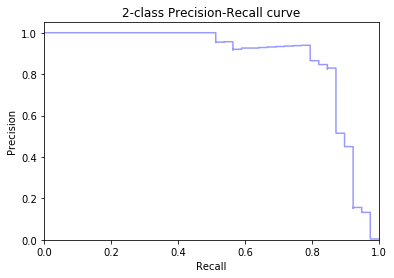

In [59]:
thresholds = np.append(thresholds, 1)
f1_scores = 2*(precision*recall)/(precision+recall)
plt.step(recall, precision, color='b', alpha=0.4, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')
plt.show()

Threshold cutoff:  0.9996215105056763
Max F1-score at cut-off :  0.8611111111111112


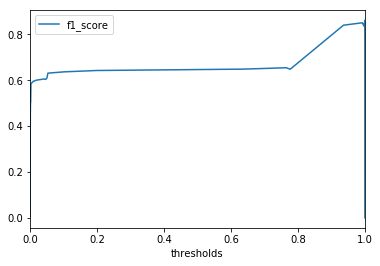

In [60]:
scrs = pd.DataFrame({'precision' : precision, 'recal' : recall, 'thresholds' : thresholds, 'f1_score':f1_scores})
print("Threshold cutoff: ",scrs.loc[scrs['f1_score'] == scrs.f1_score.max(),'thresholds'].iloc[0])
print("Max F1-score at cut-off : ",scrs.f1_score.max())

thresh = scrs.loc[scrs['f1_score'] == scrs.f1_score.max(),'thresholds'].iloc[0]

scrs.plot(x='thresholds', y='f1_score')